In [1]:
from mlxtend.frequent_patterns import apriori, association_rules
from IPython.display import display
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


In [2]:
users_file = "data/Users.xml"
posts_file = "data/Posts.xml"
comments_file = "data/Comments.xml"
badges_file = "data/Badges.xml"


def parse_xml(file: str):
    tree = ET.parse(file)
    root = tree.getroot()
    return root


users_root = parse_xml(users_file)
posts_root = parse_xml(posts_file)
comments_root = parse_xml(comments_file)
badges_root = parse_xml(badges_file)


In [3]:
# Extract user information
users_data = []
for user in users_root.findall("row"):
    user_id = user.attrib.get("Id")
    location = user.attrib.get("Location")
    reputation = int(user.attrib.get("Reputation", 0))

    users_data.append({
        "UserId": user_id,
        "Location": location,
        "Reputation": reputation
        })

users_df = pd.DataFrame(users_data)


In [4]:
# Extract posts information
posts_data = []
for post in posts_root.findall("row"):
    user_id = post.attrib.get("OwnerUserId")
    if user_id:
        posts_data.append({"UserId": user_id})

posts_df = pd.DataFrame(posts_data)
posts_count = posts_df["UserId"].value_counts().reset_index()
posts_count.columns = ["UserId", "PostsCount"]


In [5]:
# Extract comments information
comments_data = []
for comment in comments_root.findall("row"):
    user_id = comment.attrib.get("UserId")
    if user_id:
        comments_data.append({"UserId": user_id})

comments_df = pd.DataFrame(comments_data)
comments_count = comments_df["UserId"].value_counts().reset_index()
comments_count.columns = ["UserId", "CommentsCount"]


In [6]:
# Extract badges information
badges_data = []
for badge in badges_root.findall("row"):
    user_id = badge.attrib.get("UserId")
    if user_id:
        badges_data.append({"UserId": user_id})

badges_df = pd.DataFrame(badges_data)
badges_count = badges_df["UserId"].value_counts().reset_index()
badges_count.columns = ["UserId", "BadgesCount"]


# 5.1

In [7]:
# Merge dataframes
user_transactions = pd.merge(
    users_df, posts_count, on="UserId", how="left"
    )

user_transactions = pd.merge(
    user_transactions, comments_count, on="UserId", how="left"
    )

user_transactions = pd.merge(
    user_transactions, badges_count, on="UserId", how="left"
    )


for key in ("PostsCount", "CommentsCount", "BadgesCount"):
    user_transactions[key] = user_transactions[key].fillna(0).astype(int)


# Discretize reputation
user_transactions["ReputationCategory"] = pd.cut(
    user_transactions["Reputation"],
    bins=[0, 100, 1000, 10000, 100000],
    labels=["Low", "Medium", "High", "Very High"]
    )


In [8]:
display(user_transactions.head())


,UserId,Location,Reputation,PostsCount,CommentsCount,BadgesCount,ReputationCategory
0,-1,on the server farm,1,4,0,0,Low
1,1,"New York, NY",101,0,0,3,Medium
2,2,"Brooklyn, NY",907,0,0,5,Medium
3,3,"Malden, MA, USA",101,1,1,2,Medium
4,4,"Rochester, NY",1589,1,0,13,High


In [9]:
# Prepare transactions by binarizing the count features
transactions = user_transactions.drop(
    columns=["UserId", "Location", "Reputation", "ReputationCategory"]
    )

# Binarize the count features
for column in transactions.columns:
    transactions[column] = transactions[column].apply(
        lambda x: 1 if x > 0 else 0
        )

# One-hot encode the reputation categories
reputation_dummies = pd.get_dummies(
    user_transactions["ReputationCategory"],
    prefix="Reputation"
    )

transactions = pd.concat([transactions, reputation_dummies], axis=1)

# Apply Apriori algorithm
frequent_itemsets = apriori(transactions, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)


c:\Users\Studia\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [10]:
display(rules)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PostsCount),(BadgesCount),0.129848,0.809444,0.128162,0.987013,1.219372,0.023057,14.672850,0.206752
1,(BadgesCount),(PostsCount),0.809444,0.129848,0.128162,0.158333,1.219372,0.023057,1.033844,0.944108
2,(CommentsCount),(BadgesCount),0.112985,0.809444,0.111298,0.985075,1.216978,0.019844,12.767285,0.201002
3,(BadgesCount),(CommentsCount),0.809444,0.112985,0.111298,0.137500,1.216978,0.019844,1.028423,0.935640
4,(Reputation_Medium),(BadgesCount),0.623946,0.809444,0.537943,0.862162,1.065130,0.032894,1.382469,0.162602
5,(BadgesCount),(Reputation_Medium),0.809444,0.623946,0.537943,0.664583,1.065130,0.032894,1.121155,0.320887


### (PostsCount) -> (BadgesCount)
* Lift: 1.219372 - Oznacza, że posiadanie postów zwiększa szanse na posiadanie odznak o 21.94% w porównaniu do losowej próby.
* Conviction: 14.672850 - Wysoka wartość sugeruje silną zależność między postami a odznakami.

### (BadgesCount) -> (PostsCount)
* Lift: 1.219372 - Posiadanie odznak zwiększa szanse na posiadanie postów o 21.94%.

### (CommentsCount) -> (BadgesCount)
* Confidence: 0.985075 - 98.51% użytkowników z komentarzami ma również odznaki.

### (BadgesCount) -> (CommentsCount)
* Lift: 1.216978 - Posiadanie odznak zwiększa szanse na posiadanie komentarzy o 21.70%.


In [11]:
G = nx.DiGraph()
G.add_nodes_from(user_transactions["UserId"])

# Add edges based on comments
for comment in comments_root.findall("row"):
    commenter_id = comment.attrib.get("UserId")
    post_id = comment.attrib.get("PostId")
    post = posts_root.find(f"row[@Id='{post_id}']")
    if post is not None:
        post_owner_id = post.attrib.get("OwnerUserId")
        if commenter_id and post_owner_id and commenter_id != post_owner_id:
            G.add_edge(commenter_id, post_owner_id)


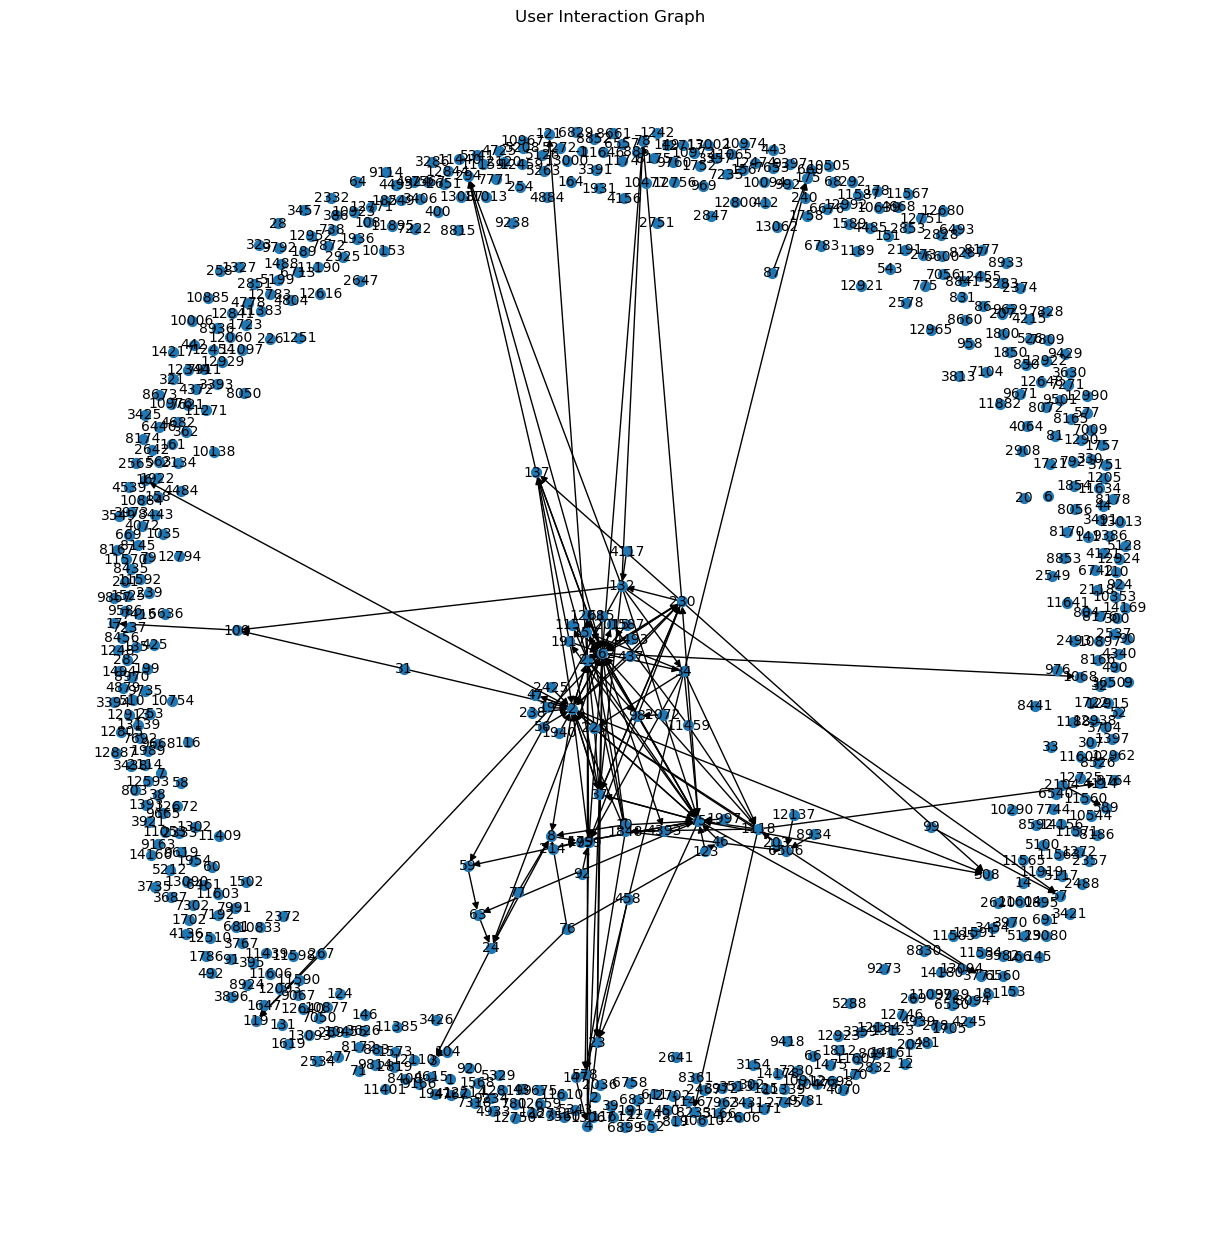

In [12]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.1)

nx.draw(
    G, pos,
    with_labels=True, node_size=50,
    font_size=10, font_color="black"
    )

plt.title("User Interaction Graph")
plt.show()
